In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # Import tqdm for the progress bar

# Transformation without normalization to compute mean and std
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor()  # Convert images to tensor
])

# Load the dataset (only for calculation, without normalization)
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/data', transform=transform)

# Create a DataLoader (no need to shuffle here since we just need to compute stats)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Initialize variables to calculate mean and std
mean = 0.0
std = 0.0
total_images = 0

# Use tqdm to show progress bar for data iteration
for images, _ in tqdm(loader, desc="Calculating mean and std", unit="batch"):
    # Compute the mean and std for each batch
    batch_samples = images.size(0)  # Number of images in the batch
    images = images.view(batch_samples, images.size(1), -1)  # Flatten each image
    mean += images.mean(2).sum(0)  # Sum along width and height (axis 2)
    std += images.std(2).sum(0)  # Sum along width and height (axis 2)
    total_images += batch_samples

# Compute the final mean and std by dividing by total images
mean /= total_images
std /= total_images

print(f'Mean: {mean}')
print(f'Standard Deviation: {std}')


Calculating mean and std: 100%|██████████| 116/116 [08:12<00:00,  4.25s/batch]

Mean: tensor([0.6314, 0.5293, 0.4935])
Standard Deviation: tensor([0.1907, 0.1813, 0.1858])


In [2]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 128x128
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize([0.6314, 0.5293, 0.4935], [0.1907, 0.1813, 0.1858])  # Normalize with mean & std for RGB
])

# Loading the dataset assuming binary folders: 'eczema' and 'normal'
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/data', transform=transform)

# Splitting dataset into 80% train, 10% validation, 10% test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 2956
Validation dataset size: 369
Test dataset size: 371


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        # BiLSTM: input=128 (channels from conv3), hidden=64, bidirectional
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 2, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # CNN Feature Extraction
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # [B, 32, 64, 64]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # [B, 64, 32, 32]
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # [B, 128, 16, 16]

        # Reshape for RNN: [B, 128, H, W] -> [B, H*W, 128]
        b, c, h, w = x.size()
        x = x.permute(0, 2, 3, 1).contiguous()  # [B, H, W, C]
        x = x.view(b, -1, c)  # [B, T, Features] → [B, 256, 128]

        # RNN: output shape = [B, T, 2*hidden]; we take the last timestep
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # last timestep

        # FC + Dropout + Output
        x = self.dropout(F.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))  # binary output

        return x


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm

num_epochs = 10
learning_rate = 0.001
momentum = 0.9
weight_decay = 0.01


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model().to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

criterion = nn.BCELoss()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", ncols=100)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    avg_loss = train_loss / len(train_loader)
    acc = 100 * correct / total
    print(f"\n Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}, Accuracy = {acc:.2f}%")

    torch.save(model, "cnn_model.pt")


Epoch [1/10]: 100%|███████████████████████████| 93/93 [14:51<00:00,  9.58s/it, acc=59.5, loss=0.645]



 Epoch 1: Avg Loss = 0.6431, Accuracy = 59.47%


Epoch [2/10]: 100%|███████████████████████████| 93/93 [00:54<00:00,  1.70it/s, acc=76.2, loss=0.447]



 Epoch 2: Avg Loss = 0.5415, Accuracy = 76.18%


Epoch [3/10]: 100%|███████████████████████████| 93/93 [00:54<00:00,  1.70it/s, acc=87.2, loss=0.359]



 Epoch 3: Avg Loss = 0.4123, Accuracy = 87.25%


Epoch [4/10]: 100%|████████████████████████████| 93/93 [00:55<00:00,  1.69it/s, acc=88.1, loss=0.36]



 Epoch 4: Avg Loss = 0.3632, Accuracy = 88.09%


Epoch [5/10]: 100%|███████████████████████████| 93/93 [00:55<00:00,  1.68it/s, acc=88.8, loss=0.355]



 Epoch 5: Avg Loss = 0.3266, Accuracy = 88.80%


Epoch [6/10]: 100%|███████████████████████████| 93/93 [00:54<00:00,  1.71it/s, acc=88.3, loss=0.317]



 Epoch 6: Avg Loss = 0.3177, Accuracy = 88.26%


Epoch [7/10]: 100%|███████████████████████████| 93/93 [00:54<00:00,  1.70it/s, acc=88.8, loss=0.247]



 Epoch 7: Avg Loss = 0.3137, Accuracy = 88.77%


Epoch [8/10]: 100%|███████████████████████████| 93/93 [00:54<00:00,  1.70it/s, acc=89.6, loss=0.193]



 Epoch 8: Avg Loss = 0.2873, Accuracy = 89.65%


Epoch [9/10]: 100%|███████████████████████████| 93/93 [00:54<00:00,  1.70it/s, acc=90.1, loss=0.282]



 Epoch 9: Avg Loss = 0.2915, Accuracy = 90.09%


Epoch [10/10]: 100%|██████████████████████████| 93/93 [00:54<00:00,  1.69it/s, acc=91.3, loss=0.253]


 Epoch 10: Avg Loss = 0.2645, Accuracy = 91.27%


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Hyperparameters
num_epochs = 10
learning_rate = 0.001
weight_decay = 0.01  # L2 regularization

# Device and model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model().to(device)

# Optimizer: Adam with L2 regularization
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Loss function
criterion = nn.BCELoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", ncols=100)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    avg_loss = running_loss / len(train_loader)
    acc = 100 * correct / total
    print(f"\n✅ Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}, Accuracy = {acc:.2f}%")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    print(f"🧪 Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.2f}%\n")

print("✅ Training complete.")

torch.save(model, "cnn_adam_model.pt")

Epoch [1/10]: 100%|███████████████████████████| 93/93 [00:54<00:00,  1.70it/s, acc=84.7, loss=0.359]



✅ Epoch 1: Avg Loss = 0.4042, Accuracy = 84.74%
🧪 Validation Loss: 0.3028, Accuracy: 88.89%



Epoch [2/10]: 100%|███████████████████████████| 93/93 [00:54<00:00,  1.70it/s, acc=88.1, loss=0.133]



✅ Epoch 2: Avg Loss = 0.3273, Accuracy = 88.06%
🧪 Validation Loss: 0.2969, Accuracy: 88.89%



Epoch [3/10]: 100%|███████████████████████████| 93/93 [00:54<00:00,  1.69it/s, acc=88.7, loss=0.124]



✅ Epoch 3: Avg Loss = 0.3107, Accuracy = 88.73%
🧪 Validation Loss: 0.3042, Accuracy: 88.08%



Epoch [4/10]: 100%|███████████████████████████| 93/93 [00:54<00:00,  1.71it/s, acc=89.4, loss=0.442]



✅ Epoch 4: Avg Loss = 0.2949, Accuracy = 89.38%
🧪 Validation Loss: 0.5706, Accuracy: 59.89%



Epoch [5/10]: 100%|███████████████████████████| 93/93 [00:54<00:00,  1.71it/s, acc=88.4, loss=0.181]



✅ Epoch 5: Avg Loss = 0.3085, Accuracy = 88.36%
🧪 Validation Loss: 0.2580, Accuracy: 88.89%



Epoch [6/10]: 100%|███████████████████████████| 93/93 [00:55<00:00,  1.66it/s, acc=89.9, loss=0.224]



✅ Epoch 6: Avg Loss = 0.2832, Accuracy = 89.85%
🧪 Validation Loss: 0.2906, Accuracy: 88.35%



Epoch [7/10]: 100%|███████████████████████████| 93/93 [00:55<00:00,  1.69it/s, acc=90.3, loss=0.146]



✅ Epoch 7: Avg Loss = 0.2855, Accuracy = 90.32%
🧪 Validation Loss: 0.2597, Accuracy: 90.79%



Epoch [8/10]: 100%|███████████████████████████| 93/93 [00:55<00:00,  1.68it/s, acc=88.8, loss=0.488]



✅ Epoch 8: Avg Loss = 0.3071, Accuracy = 88.80%
🧪 Validation Loss: 0.2996, Accuracy: 88.62%



Epoch [9/10]: 100%|███████████████████████████| 93/93 [00:56<00:00,  1.66it/s, acc=89.7, loss=0.189]



✅ Epoch 9: Avg Loss = 0.2838, Accuracy = 89.68%
🧪 Validation Loss: 0.2720, Accuracy: 89.43%



Epoch [10/10]: 100%|██████████████████████████| 93/93 [00:55<00:00,  1.69it/s, acc=90.4, loss=0.578]



✅ Epoch 10: Avg Loss = 0.2779, Accuracy = 90.43%
🧪 Validation Loss: 0.2641, Accuracy: 90.24%

✅ Training complete.


✅ Model loaded from Drive.
Accuracy    : 0.9079
Precision   : 0.8723
Recall      : 0.8849
F1 Score    : 0.8786
Specificity : 0.9217
ROC AUC     : 0.9533


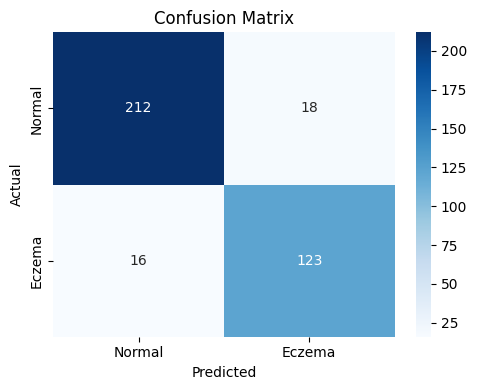

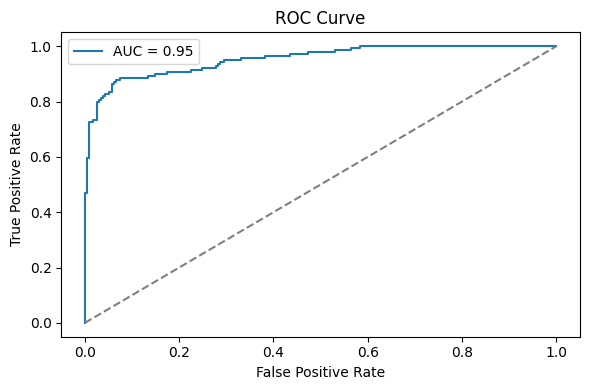

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/cnn_model.pt"  # <-- update path
model = torch.load(model_path, map_location=device, weights_only=False)
model = model.to(device)
model.eval()
print("✅ Model loaded from Drive.")

# 🧪 Evaluation function
def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            probs = outputs.cpu().numpy()
            preds = (outputs > threshold).float().cpu().numpy()
            y_probs.extend(probs)
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp + 1e-6)

    print(f"Accuracy    : {acc:.4f}")
    print(f"Precision   : {prec:.4f}")
    print(f"Recall      : {rec:.4f}")
    print(f"F1 Score    : {f1:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"ROC AUC     : {auc:.4f}")

    # Confusion Matrix Plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Eczema'], yticklabels=['Normal', 'Eczema'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC Curve Plot
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 🔁 Run it on val_loader or test_loader
evaluate_model(model, val_loader)  # or test_loader if available


✅ Model loaded from Drive.
Accuracy    : 0.8922
Precision   : 0.8367
Recall      : 0.8849
F1 Score    : 0.8601
Specificity : 0.8966
ROC AUC     : 0.9556


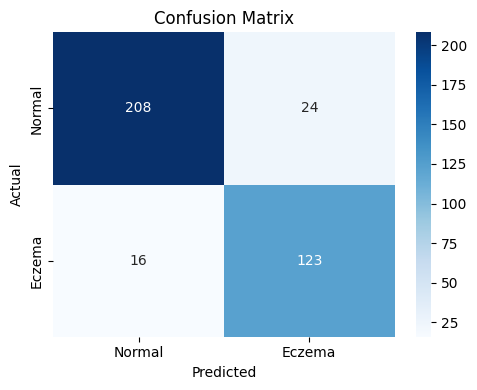

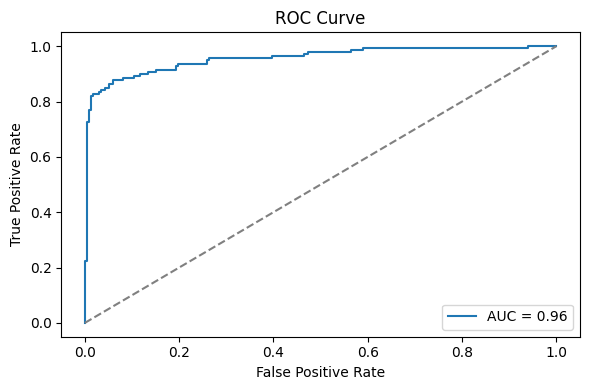

In [10]:

# 🔧 Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 🔌 Load model from Drive
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/cnn_model.pt"  # <-- update path
model = torch.load(model_path, map_location=device, weights_only=False)
model = model.to(device)
model.eval()
print("✅ Model loaded from Drive.")

# 🧪 Evaluation function
def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            probs = outputs.cpu().numpy()
            preds = (outputs > threshold).float().cpu().numpy()
            y_probs.extend(probs)
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp + 1e-6)

    print(f"Accuracy    : {acc:.4f}")
    print(f"Precision   : {prec:.4f}")
    print(f"Recall      : {rec:.4f}")
    print(f"F1 Score    : {f1:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"ROC AUC     : {auc:.4f}")

    # Confusion Matrix Plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Eczema'], yticklabels=['Normal', 'Eczema'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC Curve Plot
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 🔁 Run it on val_loader or test_loader
evaluate_model(model, test_loader)  # or test_loader if available
